# Deep Learning for Business Applications course

## TOPIC 11: Word Embeddings (Word2Vec, CBOW, Skip-gram)

Today we are going to study another approach to make a vector representation of words called word embeddings. This approach allows you to encode words as vectors so that words that are close in meaning are close to each other in the resulting vector space. Embeddings are used everywere in machine learning. Embedding can be associated with almost any object, be it a word, symbol, text, picture, video, graph, etc.

You already know about bag-of-words(BOW) which is simple and interpretable approach for making vector representations of texts. But it has a disadvantage.

Recall the BOW approach implies that the features of the document is a words, which means that the size of the feature space is equal to the number of unique words in the corpus (this set of words called vocabulary). Thus, a feature space of very high dimension is obtained. Moreover, the feature matrix turns out to be sparse, that is, it contains a lot of zeros, since the documents do not contain most of the words from the vocabulary. A large number of features can lead to decreasing speed of model training and inference as well as decreasing of model quality especially for models based on the calculation of distances between points in feature space. The last problem called the curse of dimensionality.

To avoid this problems one need to compress feature space. Neural networks will help us to deal with this.

### 1. One-hot encoding

Before learning about neural network architectures one need to understand how to feed the words to them because neural network, like any model, takes vectors as input (or tensor in general).

The easiest way to represent words as a vector is one-hot encoding. First, we assign an unique index to each word. It can be done using dictionary with words as keys and indexes as values. This dictionary is called vocabulary and it contains all words in corpus. Then we transform each index to vector with the same lengths as the vocabulary. Each vector component filled by zeros except position corresponding to index: it's equal to one.

Let's look at the example. Suppose we have a corpus with two texts:

* `The quick brown fox jumps`
* `fox jumps quick`

Then encoded representation of texts may look like this.

First text:
<table>
  <tr>
    <th>Word</th> <th>Index</th> <th>One-hot vector</th>
  </tr>
  <tr>
    <td>The</td> <td>1</td> <td>[1, 0, 0, 0, 0]</td>
  </tr>
  <tr>
    <td>quick</td> <td>2</td> <td>[0, 1, 0, 0, 0]</td>
  </tr>
  <tr>
    <td>brown</td> <td>3</td> <td>[0, 0, 1, 0, 0]</td>
  </tr>
  <tr>
    <td>fox</td> <td>4</td> <td>[0, 0, 0, 1, 0]</td>
  </tr>
  <tr>
    <td>jumps</td> <td>5</td> <td>[0, 0, 0, 0, 1]</td>
  </tr>
</table>

Second text:
<table>
  <tr>
    <th>Word</th> <th>Index</th> <th>One-hot vector</th>
  </tr>
  <tr>
    <td>fox</td> <td>4</td> <td>[0, 0, 0, 1, 0]</td>
  </tr>
  <tr>
    <td>jumps</td> <td>5</td> <td>[0, 0, 0, 0, 1]</td>
  </tr>
  <tr>
    <td>quick</td> <td>2</td> <td>[0, 1, 0, 0, 0]</td>
  </tr>
</table>

Each component of one hot vector is a value of feature.


### 2. Embedding layer

Embedding layer is just a regular linear layer with some modifications and optimizations made to simplify our life and speed up learning and inference.

The first modification is that the layer takes as input not one-hot vectors, but indexes of words from the dictionary. It transforms indices to vectors by itself and allows us not to bother with one-hot encoding.

Since this is a linear layer, its weights are a matrix. The one-hot vector is multiplied by this matrix to get the embedding vector. If vocabulary size is equal to $v$ then dimension of the one-hot vector will be $1 \times v$. If we want to transform the one-hot vector to the embedding vector with dimension $u$ then the matrix should have dimension $v \times u$.

Let's see how this layer works with an example of word `fox`.

Suppose we have an embedding layer with a following matrix:

$$
    \begin{pmatrix}
        0.1 & 0.2 & -0.3 \\
        0.4 &- 0.5 & 0.6 \\
        -0.7 & 0.8 & 0.9 \\
        0.3 & 0.2 & -0.1 \\
        0.6 & -0.5 & 0.4
    \end{pmatrix}
$$

First of all, embedding layer will map index of word `fox` to one-hot vector $4 ⟶ \begin{pmatrix}0 & 0 & 0 & 1 & 0\end{pmatrix}$.

Then one-hot vector will be multiplied by embedding matrix:

$$
    \begin{pmatrix}
        0 & 0 & 0 & 1 & 0
    \end{pmatrix}
    \times
    \begin{pmatrix}
        0.1 & 0.2 & -0.3 \\
        0.4 &- 0.5 & 0.6 \\
        -0.7 & 0.8 & 0.9 \\
        0.3 & 0.2 & -0.1 \\
        0.6 & -0.5 & 0.4
    \end{pmatrix}
    =
    \begin{pmatrix}
        0.3 & 0.2 & -0.1
    \end{pmatrix}
$$

As you can see we took vector of dimension $1 \times 5$ multiplied by matrix with dimension $5 \times 3$ and got vector $1 \times 3$. Thus, we have reduced the dimension of the feature space.

Note that the embedding is exactly the 4th row of the embedding matrix, so there is no need to implement the matrix multiplication rule on forward step. It is enough to select a row from the embedding matrix that corresponds to the index of the word in the vocabulary. The same goes for the backward step: the weights are only updated in the row that matches the word's index.

Thus, at the training stage we need to find the weights of the embedding matrix and at the inference pull out the row corresponding to the word's index from the matrix.

### 3. Word2vec

Word2vec is a common technique for making vector representations of words in text using neural networks. There are two architectures implementing this technique: continuous bag-of-words (CBOW) and continuous skip-gram.

Suppose we have a text consisting of a sequence of words $w_{1},w_{2},...,w_{t},... w_{n}$. The context of a word $w_{t}$ is a sequence of words $w_{t-l},...,w_{t-2},w_{t-1},w_{t+1},w_{t+2},...,w_{t+l}$, where $l$ is called window. Thus, the context is the words that are at a distance of no more than $l$ to the left and to the right of the current word.

For word `fox` in sentence `The quick brown fox jumps over the lazy dog.` context with `window=2` will be `quick, brown, jumps, over`.

### 4. CBOW

The idea of CBOW is to predict word by its context. This can be shown in the following picture.

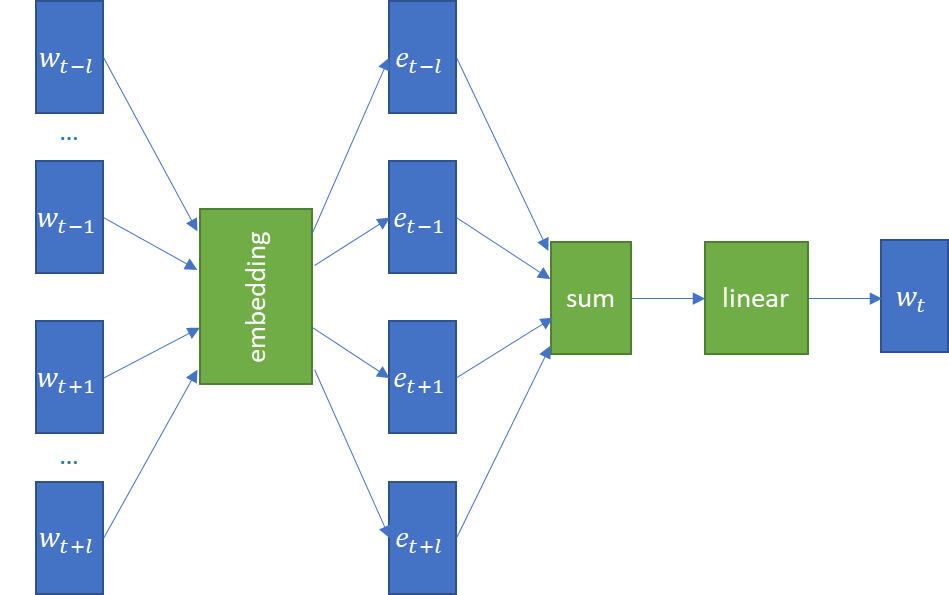

Network takes indexes of context as input, transforms them to the embeddings, sums them up element wise and transform the result to the target word using linear layer. On the training stage we compare output logits with the one-hot vector or index of the target word calculating cross entropy loss.

$$L(θ) = -\sum_{i=1}^{m} \sum_{k=1}^{K}{y_{ik} log(p_{ik}(x, θ))}$$

where $m$ is count of pairs <context, word> in the dataset/batch, $K$ - number of classes(vocabulary size), $y_{ik}$ - values in one-hot representation of target words, $x$ - context indices, $θ$ - model weights, $p_{ik}(x, θ)$ - output probabilities of each word from network.

This is how training and inference will look like using the example of predicting the word "quick" with a `window = 1`.


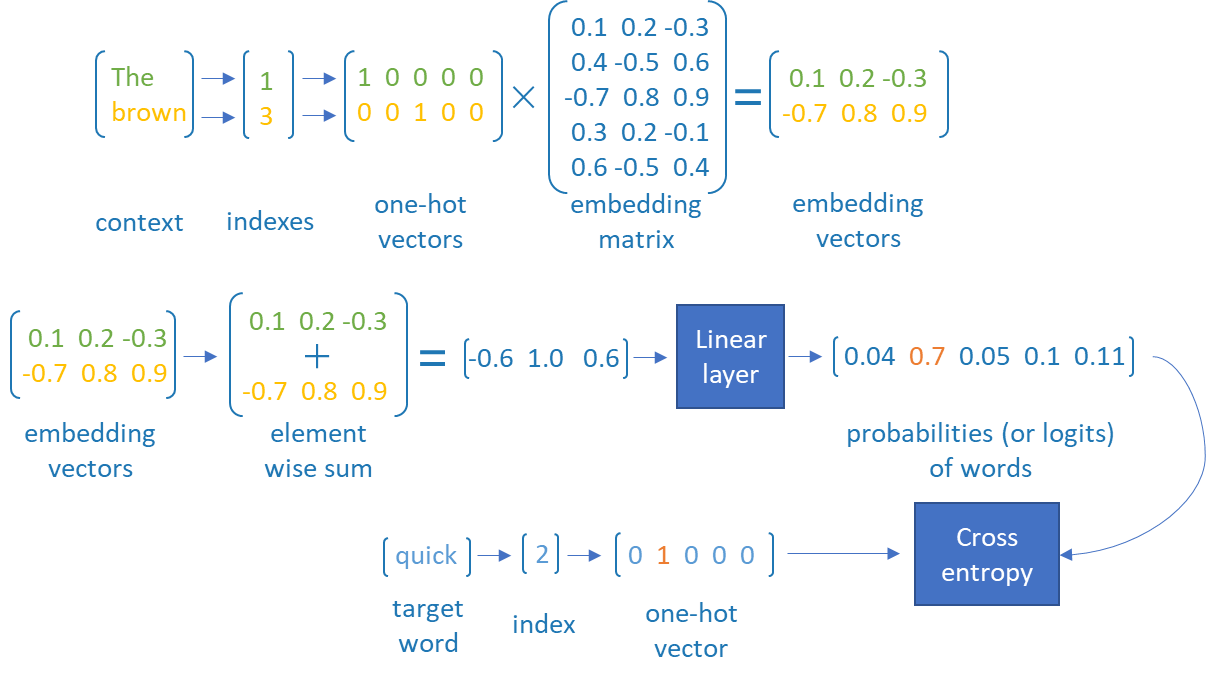

In this work we will implement CBOW from scratch.

### 5. Skip-gram

The idea of Skip-gram is opposite to CBOW. It predicts context by word. This can be shown in the following picture.

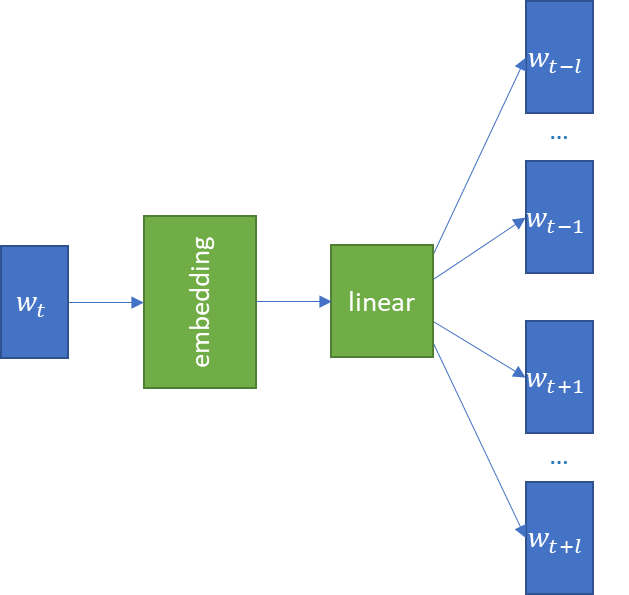

This architecture a little bit simplier. To train the network one need to feed word $w_{t}$ to embedding and linear layer and predict word $w_{t-l}$. Then one need too feed word $w_{t}$ to network again but predict word $w_{t-l+1}$ and so on. Basically we just repeat input word for each surrounding word at the dataset creation stage and then we solve usual multiclass classification task.

You can read more about this architectures in <a href="https://arxiv.org/pdf/1301.3781.pdf">original paper</a>.

### 6. Data
#### 6.1. Data preparation

In this work we will be using data from standart sklearn dataset `20newsgroups`. The dataset contains corpus where each text belongs to one of 20 newsgroups. Texts are just a messages from users.

Let's save the data in two variables:

* `corpus` is a list of texts
* `target` is a name of group:
    * rec - texts about sport, auto etc.
    * comp - texts about computers.
    * sci - texts about science.
    * soc - texts about religion.
    * talk - texts about politics.
    * misc - miscelaneous.
    * alt - texts about atheism.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups()

corpus = news['data']
target = [news.target_names[i].split('.')[0] for i in news.target]

print('Corpus size:', len(corpus))
print()
print('Text example:', corpus[4])

In [ ]:
print('Target values:', set(target))

We see that text contains trash symbols like this `>>>`, e-mails, maybe links etc. First of all we need to clean it.

#### 6.2. Data preprocessing

In [ ]:
DATASPHERE = False

if DATASPHERE:
    # !!! ATTENTION for DataSphere !!!
    # You will need to restart kernel
    # after libraries installed
    from spacy.cli import download
    download("en_core_web_sm") 
else:
    !pip install spacy
    !python -m spacy download en_core_web_sm

In [ ]:
# import some useful libraries
import numpy as np
import pandas as pd
import spacy
import re
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

This time will use library spacy for cleaning and lemmatization.

In [ ]:
# We will remove every symbol except english letters, spaces and apostrophes.
cleaner = re.compile('[^A-Za-z \']')

# Load spacy model for english.
nlp = spacy.load('en_core_web_sm')

# Create pipe object over our courpus and disable unnecessary steps 
# like `ner`(named entity recognition)

pipe = nlp.pipe(corpus, disable=['parser', 'ner'])

# Pipe is a generator of documents, each of which contains tokens. 
# Token is a word with a useful attributes and methods.
# For example, attribute `lemma_` contains normal form of word.
# Full list of attributes: https://spacy.io/api/token#attributes

docs = []  # list containing tokenized documents

for doc in tqdm(pipe, total=len(corpus)):
    lemmas = []

    for token in doc:
        if not (
            token.is_punct or
            token.is_space or
            token.is_stop or
            token.like_email or
            token.like_num or
            token.like_url
        ):
            lemma = token.lemma_
            lemma = cleaner.sub('', lemma)
            if len(lemma) > 1:
                lemma = lemma.lower()
                lemmas.append(lemma)

    docs.append(lemmas)

In [ ]:
print('First 10 words from previous text example:', docs[4][:10])

### 7. CBOW implementation from scratch

Let's try to implement CBOW using pytorch library.

In [ ]:
# import neccesary packages
import torch
import torch.nn as nn  # layers
import torch.nn.functional as F  # functions like cross entropy
from torch.optim import AdamW  # Optimizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler  # data generation
from collections import Counter

In [ ]:
# make torch deterministic
SEED = 2025

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

First thing you should do is to create vocabulary from corpus.

1. Count how many times each word occurs in the corpus. You can use `Counter` for this purpose.
2. Remove words that occurs less than `min_count`.
3. Create `vocab_id` - dictionary with words as keys and their indices as values. Add special word `'PAD'` with index `0`.

What is `'PAD'`? Each text contains a different number of words, i.e. index sequences will have different lengths. But pytorch works with tensors and the dimensions of a tensor are fixed length. Thus, if the length of the sequence is less than the dimension of the tensor, then it is necessary to complement it to the dimension.

In [ ]:
min_count = 5

word_counter = Counter([word for doc in docs for word in doc])
vocab = ['PAD'] + [k for k, v in word_counter.items() if v >= min_count]
vocab_id = {word: id for id, word in enumerate(vocab)}

Form a corpus of indexes by matching each word with its index from the dictionary

In [ ]:
docs_id = [[vocab_id[word] for word in doc if word in vocab_id] for doc in docs]

In [ ]:
# Check documents

for i in (0, 1):
    print(docs_id[i])

Now one can create a dataset from words and their corresponding contexts.
Implement a fuction `make_contexts` below. It takes two parameters:

* `docs_id` - corpus of identifiers from previous step.
* `window` - context length.

If the window does not cover the required number of indices, then you need to add padding indexes to the sequence.

Example.

Input:
```
docs_id = [
    [1, 2, 3, 4, 5, 6, 7, 8],
    [44, 1, 2, 46, 47]
]
window = 3
```

Output:

```
contexts = [
    [0, 0, 0, 2, 3, 4],
    [0, 0, 1, 3, 4, 5],
    [0, 1, 2, 4, 5, 6],
    [1, 2, 3, 5, 6, 7],
    [2, 3, 4, 6, 7, 8],
    [3, 4, 5, 7, 8, 0],
    [4, 5, 6, 8, 0, 0],
    [5, 6, 7, 0, 0, 0],
    [0, 0, 0, 1, 2, 46],
    [0, 0, 44, 2, 46, 47],
    [0, 44, 1, 46, 47, 0],
    [44, 1, 2, 47, 0, 0],
    [1, 2, 46, 0, 0, 0]
]
words = [1, 2, 3, 4, 5, 6, 7, 8, 44, 1, 2, 46, 47])
```


In [ ]:
def make_contexts(docs_id, window=5):

    contexts = []  # save contexts here
    words = []  # save corresponding words here

    for doc_id in docs_id:  # iterate over each document with ids

        if len(doc_id) >= window:  # skip docs shorter than window

            for i in range(len(doc_id)):  # iterate over each word id

                context_left = doc_id[max(i - window, 0) : i]
                context_right = doc_id[i + 1 : i + window + 1]

                if len(context_left) < window:
                    context_left = [0] * (window - len(context_left)) + context_left

                if len(context_right) < window:
                    context_right = context_right + [0] * (window - len(context_right))

                contexts.append(context_left + context_right)
                words.append(doc_id[i])

    return contexts, words

In [ ]:
contexts, words = make_contexts(docs_id)

In [ ]:
print(contexts[0], words[0])
print(contexts[7], words[7])
print(contexts[1984], words[1984])

In [ ]:
# At the training stage, we will feed several sequences as input, in other words, batch.
batch_size = 4096  # `16384` for GPU

# As we know pytorch works with tensors, so we should transform lists of indices to tensors.
X = torch.tensor(contexts)
y = torch.tensor(words)

# We have to take care of batch generation.
# One need to create a dataset from our tensors. Use the prebuilt TensorDataset class
# In some cases its better to create your own implementation of dataset.

dataset = TensorDataset(X, y)

# Create a dataloader from your `dataset` and set `batch_size`. Use RandomSampler for sampling strategy.
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=RandomSampler(dataset))

print(X.shape, y.shape)

In [ ]:
# Look at what dataset does
dataset[1]

In [ ]:
# Look at the generated batch
for X_batch, y_batch in dataloader:
    print('X shape: ', X_batch.shape)
    print('y shape: ', y_batch.shape)
    print('X_batch: ', X_batch)
    print('y_batch: ', y_batch)
    break

It's time to define architecture of the neural network according to CBOW picture.

You need `nn.Embedding(...)`, and `nn.Linear(...)` layers and aggregate functions like `torch.sum(...)` or `torch.mean(...)`

In [ ]:
class CBOW(nn.Module):  # All models should inherit this base class

    def __init__(self, vocab_size, embedding_size=64):
        '''
        This method should contain all layers and parameters of the model.

        :vocab_size - len of our vocab
        :embedding_size - size of the embedding vector
        '''

        super().__init__()  # call base class constructor

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        # Create layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)

        self.linear = nn.Linear(in_features=embedding_size, out_features=vocab_size)

    def forward(self, x):
        '''
        This method should implement forward pass. Backward pass is automatic,
        thanks to automatic differentiation.

        :x - input tensor with containing sequences of indicies.

        Recall you will use the batch optimization. That is, several contexts
        will be fed to the network input at once. Therefore, the dimension of
        the input tensor will be equal to (batch_size, window * 2).

        Remember that the embedding layer changes the dimension of
        the input tensor. If the input dimension was (batch_size, window * 2)
        then the output tensor will have the dimension
        (batch_size, window * 2, embedding_size).
        '''

        x = self.embedding(x)
        x = torch.mean(x, axis=1)
        out = self.linear(x)

        return out

It would be interesting to visualize texts at 3D scatter plot. So let's create CBOW model with embedding size equal 3.

In [ ]:
# Set number of epochs.
epochs = 10

# Create model
model = CBOW(len(vocab), embedding_size=3)

# Create optimizer
optimizer = AdamW(model.parameters(), lr=0.001)

# Choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import matplotlib.pyplot as plt


def draw_learning_curve_colab(losses, range_x=None):

    from google.colab import output
    
    output.clear(True)
    fig = px.line(title='Learning curve', range_x=range_x, template='plotly_dark')
    fig.add_scatter()
    fig['data'][0]['x'] = list(range(len(losses)))
    fig['data'][0]['y'] = losses
    fig.update_layout(yaxis={'title': 'Loss'}, xaxis={'title': 'Training step'}, title={'x': 0.5})
    fig.show(renderer="colab")


def draw_learning_curve(losses, range_x=None):
    """
    Function to draw learning curve.
    
    """
    from IPython.display import clear_output
    clear_output(wait=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2)
    plt.title('Learning Curve', fontsize=14, pad=20)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    if range_x is not None:
        plt.xlim(range_x)
    
    plt.tight_layout()
    plt.show()

We are ready to implement the training cycle in `train(...)` function.

In [ ]:
def train(model, dataloader, optimizer, epochs, device='cuda', draw=True):
    """
    The functioin takes following parameters

    :model - CBOW model.
    :dataloader - TensorDataloader.
    :optiizer - just optimizer.
    :epochs - number of cycle iterations.
    :device - 'cuda' for GPU, 'cpu' for CPU.
    :draw - True if we want to show learning curve.
    
    """
    model.to(device)  # move model to chosen divece
    model.train()  # set training mode

    # calculate how many batches goes through network. Just for visualization
    num_training_steps = epochs * len(dataloader)

    losses = []  # losses is saved here
    i = 0  # draw learning curve after each 10 batches
    for e in range(epochs):  # cycle over epochs

        for X_batch, y_batch in dataloader:  # cycle over batches

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # move data to chosen device

            model.zero_grad()  # set gradients to zero before calculating them

            # You need to execute forward pass and calculate loss.
            outputs = model(X_batch)
            loss = F.cross_entropy(outputs, y_batch)
            losses.append(loss.item())  # save loss

            loss.backward()  # calculate gradients (backpropagation)
            optimizer.step()  # update weights of a model

            if draw and i % 10 == 0: # draw curve
                draw_learning_curve(losses, range_x=(0, num_training_steps))

            i += 1

    model.to('cpu')  # move model back to CPU
    model.eval()  # set evaluation mode

In [ ]:
%%time

# train!
train(model, dataloader, optimizer, epochs, device=device)

In [ ]:
# To get the word embeddings, we only need the embedding layer weights

embeddings = model.embedding.weight.detach().numpy()
embeddings.shape

In [ ]:
# Create a dictionary with words as keys and embeddings as values

wv = {word: embeddings[i, :] for word, i in vocab_id.items()}

# Look at the embedding vector of word 'peace'
wv['peace']

In [ ]:
# Let's clean GPU memory
if device == 'cuda':
    import gc
    model = None
    gc.collect()
    torch.cuda.empty_cache()

How to get text embeddings knowing word embeddings in them? Well, you can, for example, average all the embeddings of words in the text.

Implement a function that takes corpus and `wv` dictionary and returns numpy array with embeddings of each document.

In [ ]:
def get_docs_embeddings(docs, wv):

    docs_embeddings = np.array(
        [np.array([wv[word] for word in doc if word in wv.keys()]).mean(axis=0)
        for doc in docs]
    )

    return docs_embeddings

In [ ]:
doc_embeddings = get_docs_embeddings(docs, wv)
doc_embeddings.shape

In [ ]:
def plot3d(corpus, target, doc_embeddings):
    """
    Draws scatter plot.
    
    """
    df = pd.DataFrame(
        dict(
            corpus=corpus, 
            target=target, 
            emb0=doc_embeddings[:, 0], 
            emb1=doc_embeddings[:, 1], 
            emb2=doc_embeddings[:, 2]
        )
    )
    df['corpus'] = df['corpus'].apply(lambda x: re.sub('\n', '<br>', x))
    df.head()

    fig = px.scatter_3d(
        df, 
        x='emb0', y='emb1', z='emb2', 
        color='target', 
        hover_data=['corpus'], 
        width=1024, height=768, 
        template='plotly_dark'
    )
    fig.update_traces(marker=dict(size=6))
    fig.show()

In [ ]:
plot3d(corpus, target, doc_embeddings)

### 8. Gensim Word2Vec

We implemented original CBOW. But actually Word2Vec models are already implemented in gensim library. Their implementation is better and contains modifications that improve the quality of the model.

Documentation: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
from gensim.models import Word2Vec

In [ ]:
%%time

gensim_model = Word2Vec(docs, workers=2, vector_size=3, window=5, min_count=5, seed=2025)

In [ ]:
gensim_wv = {word: gensim_model.wv[word] for word in gensim_model.wv.index_to_key}

In [ ]:
gensim_embeddings = get_docs_embeddings(docs, gensim_wv)
gensim_embeddings.shape

In [ ]:
plot3d(corpus, target, gensim_embeddings)